In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder
import shap 

import warnings
warnings.filterwarnings("ignore")
from warnings import simplefilter
simplefilter("ignore", category=RuntimeWarning)

In [2]:
import optuna 
from sklearn import preprocessing,metrics
from sklearn.model_selection import  StratifiedKFold, train_test_split,cross_val_score
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn import tree 
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier

In [3]:
plt.rcParams['font.family'] = ['Times New Roman']

In [4]:
def metric_calculation(y,y_pred):
    tp = np.count_nonzero((y_pred == y) & (y == 1))
    fn = np.count_nonzero((y_pred != y) & (y == 1))
    tn = np.count_nonzero((y_pred == y) & (y == 0))
    fp = np.count_nonzero((y_pred != y) & (y == 0))
    # sen = tp / (tp + fn) ## metrics.recall_score
    spc = tn / (tn + fp)
    # ppv = tp / (tp + fp) ## metrics.precision_score 
    npv = tn / (fn + tn) 
    return round(spc,4),round(npv,4)

In [5]:
def table2df(result):
    # auc,acc,f1,recall,spc,precision,npv
    df_result = pd.DataFrame({'cutoff':[item[0] for item in result],
                            'ACC':[item[-1][1] for item in result],
                            'AUC':[item[-1][0] for item in result],
                            'F1': [item[-1][2] for item in result],
                            'SEN':[item[-1][3] for item in result],
                            'SPC':[item[-1][4] for item in result],
                            'PPV':[item[-1][5] for item in result],
                            'NPV':[item[-1][6] for item in result]})
    return df_result 

## Import data

In [6]:
data = pd.read_excel('../../HTdata/HT_table_20240227_clean_final.xlsx', sheet_name='All_clean')

data = data.rename(columns={'NIHSS':'NIHSS score at admission',
                         'DM':'Diabetes mellitus',
                         'TIME3': 'Time from onset to MRI',
                         'ADC<620':'$\\mathregular{ADC} < 620 × \\mathregular{10}^{-6} \\mathregular{mm}^2/\\mathregular{s}$',
                         'Tmax>4 Volume': 'Tmax > 4 s',
                         'Tmax>6 Volume': 'Tmax > 6 s',
                         'Tmax>8 Volume': 'Tmax > 8 s',
                         'Tmax>10 Volume': 'Tmax > 10 s',
                         'PWI-DWI Mismatch':'PWI-DWI mismatch',
                         'VTmax>10s/VTmax>6s':'HIR',
                         'Tmax/DWI Ratio': 'Tmax/DWI Ratio'})


features = ['Age', 'Gender', 'NIHSS score at admission', 'Diabetes mellitus', 'Hypertension', 'Atrial fibrillation', 
            'Time from onset to MRI',  
            '$\\mathregular{ADC} < 620 × \\mathregular{10}^{-6} \\mathregular{mm}^2/\\mathregular{s}$', 
            'Tmax > 4 s', 'Tmax > 6 s', 'Tmax > 8 s', 'Tmax > 10 s', 
            'PWI-DWI mismatch', 'HIR']

X_ = data[features]
## convert mismatch < 0 -> = 0:
X_['PWI-DWI mismatch'][X_['PWI-DWI mismatch'] < 0] = 0 

y = data['Group']
X = X_.copy()
le = LabelEncoder()
X[X.columns[1]] = le.fit_transform(X_.loc[:, 'Gender'])


print(X.shape)

(379, 14)


In [7]:
random_seed = 628
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=random_seed)
scalar = preprocessing.StandardScaler().fit(X_train)
X_train_sc = scalar.transform(X_train)
X_test_sc = scalar.transform(X_test)
print(X_train.shape)
print(X_test.shape)

(265, 14)
(114, 14)


## Baseline model

In [8]:
import pickle 
# load model
with open('./model.pkl','rb') as out_file:
    models = pickle.load(out_file)

best_model_lr = models['lr']
best_model_svm = models['svm']
best_model_dt = models['dt']
best_model_xgb = models['xgb']
best_model_gbm = models['gbm']
best_model_rf = models['rf']

In [9]:
import scipy.stats

confidence = 0.95  # Change to your desired confidence level
z_value = scipy.stats.norm.ppf((1 + confidence) / 2.0)
print(z_value)

1.959963984540054


In [29]:
metrics = {'acc':accuracy_score,
           'auc':roc_auc_score,
           'f1':f1_score,
           'sen':recall_score,
           'ppv':precision_score}

In [31]:
for model_name in ['lr','svm','dt','xgb','gbm','rf']:
    model = models[model_name]
    print(f'MODEL {model_name} processing')
    
    if (model_name == 'rf') or (model_name == 'dt'):
        y_pred_prob = model.predict_proba(X_test)[:,1]
        y_pred = model.predict(X_test)
    else:
        if (model_name == 'svm'):
            y_pred_prob = 1/ (1+np.exp(-model.decision_function(X_test_sc))) 
            y_pred = model.predict(X_test_sc)
        else:
            y_pred_prob = model.predict_proba(X_test_sc)[:,1]
            y_pred = model.predict(X_test_sc)
    
    for metric in ['acc','auc','f1','sen','spc','ppv','npv']:
        print(f'METRIC {metric} result')
        
        if metric in ['spc']:
            acc_test,_ = metric_calculation(y_test,y_pred)
        elif metric in  ['npv']:
            _,acc_test = metric_calculation(y_test,y_pred)
        elif metric in ['auc']:
            m = metrics[metric]
            acc_test = m(y_test, y_pred_prob)
        else:
            m = metrics[metric]
            acc_test = m(y_test, y_pred)
            
        ci_length = z_value * np.sqrt((acc_test * (1 - acc_test)) / y_test.shape[0])

        ci_lower = acc_test - ci_length
        ci_upper = acc_test + ci_length

        print(f'{round(acc_test,2)} ({round(ci_lower,2)}-{round(ci_upper,2)})')
    
    print('*'*80)

MODEL lr processing
METRIC acc result
0.84 (0.78-0.91)
METRIC auc result
0.91 (0.85-0.96)
METRIC f1 result
0.79 (0.71-0.86)
METRIC sen result
0.85 (0.78-0.91)
METRIC spc result
0.84 (0.77-0.91)
METRIC ppv result
0.73 (0.65-0.81)
METRIC npv result
0.91 (0.86-0.96)
********************************************************************************
MODEL svm processing
METRIC acc result
0.83 (0.76-0.9)
METRIC auc result
0.89 (0.83-0.94)
METRIC f1 result
0.76 (0.68-0.84)
METRIC sen result
0.77 (0.69-0.85)
METRIC spc result
0.87 (0.8-0.93)
METRIC ppv result
0.75 (0.67-0.83)
METRIC npv result
0.88 (0.82-0.94)
********************************************************************************
MODEL dt processing
METRIC acc result
0.76 (0.69-0.84)
METRIC auc result
0.87 (0.81-0.93)
METRIC f1 result
0.72 (0.64-0.8)
METRIC sen result
0.9 (0.84-0.95)
METRIC spc result
0.69 (0.61-0.78)
METRIC ppv result
0.6 (0.51-0.69)
METRIC npv result
0.93 (0.88-0.98)
**************************************************

## Voting (soft)

In [32]:
from sklearn.ensemble import VotingClassifier

In [40]:
# # soft voting
classifiers = [('xgb',best_model_xgb),
               ('gbm',best_model_gbm),
               ('rf',best_model_rf)]

# Create a voting classifier.
voting_clf = VotingClassifier(estimators=classifiers, voting='soft')

# # Train voting classifier
voting_clf.fit(X_train_sc,y_train)

y_pred = voting_clf.predict(X_test_sc)
y_pred_prob_voting = voting_clf.predict_proba(X_test_sc)[:,1]

for metric in ['acc','auc','f1','sen','spc','ppv','npv']:
    print(f'METRIC {metric} result')
    
    if metric in ['spc']:
        acc_test,_ = metric_calculation(y_test,y_pred)
    elif metric in  ['npv']:
        _,acc_test = metric_calculation(y_test,y_pred)
    elif metric in ['auc']:
        m = metrics[metric]
        acc_test = m(y_test, y_pred_prob_voting)
    else:
        m = metrics[metric]
        acc_test = m(y_test, y_pred)
        
    ci_length = z_value * np.sqrt((acc_test * (1 - acc_test)) / y_test.shape[0])

    ci_lower = acc_test - ci_length
    ci_upper = acc_test + ci_length

    print(f'{round(acc_test,2)} ({round(ci_lower,2)}-{round(ci_upper,2)})')




[LightGBM] [Info] Number of positive: 92, number of negative: 173
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 434
[LightGBM] [Info] Number of data points in the train set: 265, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347170 -> initscore=-0.631503
[LightGBM] [Info] Start training from score -0.631503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


## Stacking

In [41]:
from sklearn.ensemble import StackingClassifier

In [43]:
classifiers = [('xgb',best_model_xgb),
               ('gbm',best_model_gbm),
               ('rf',best_model_rf)]
stacking_clf = StackingClassifier(estimators=classifiers, 
                                  final_estimator=linear_model.LogisticRegression())
stacking_clf.fit(X_train_sc,y_train)

y_pred = stacking_clf.predict(X_test_sc)
y_pred_prob_stacking = stacking_clf.predict_proba(X_test_sc)[:,1]

for metric in ['acc','auc','f1','sen','spc','ppv','npv']:
    print(f'METRIC {metric} result')
    
    if metric in ['spc']:
        acc_test,_ = metric_calculation(y_test,y_pred)
    elif metric in  ['npv']:
        _,acc_test = metric_calculation(y_test,y_pred)
    elif metric in ['auc']:
        m = metrics[metric]
        acc_test = m(y_test, y_pred_prob_stacking)
    else:
        m = metrics[metric]
        acc_test = m(y_test, y_pred)
        
    ci_length = z_value * np.sqrt((acc_test * (1 - acc_test)) / y_test.shape[0])

    ci_lower = acc_test - ci_length
    ci_upper = acc_test + ci_length

    print(f'{round(acc_test,2)} ({round(ci_lower,2)}-{round(ci_upper,2)})')



[LightGBM] [Info] Number of positive: 92, number of negative: 173
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 434
[LightGBM] [Info] Number of data points in the train set: 265, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347170 -> initscore=-0.631503
[LightGBM] [Info] Start training from score -0.631503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


## Prior model

#### modules

In [12]:
def tree_ensemble(X_train,X_train_sc,y_train,feature_train,X_test,X_test_sc,y_test,feature_test,feature_name,cutoff,state=None,tree_structure=None):
    '''
    feature: which feature to split
    cutoff: should within the range of feature values
    state: train or test
    tree_structure: dict format
                    {'L':'rf', 'R':'lr'}
                    <= cutoff: rf
                    > cutoff : lr
    ''' 
    if state == 'train':
        data = X_train 
        data_sc = X_train_sc
        y = y_train
        feature_val = feature_train
    else:
        data = X_test
        data_sc = X_test_sc
        y = y_test
        feature_val = feature_test
     
    
    y_pred_prob =[]
    y_pred = [] 
    
    # build tree
    for i in range(len(data)):
        if feature_val[i] <= cutoff:
            if tree_structure['L'] == 'RF':
                pred_prob = best_model_rf.predict_proba(data.iloc[i].to_numpy().reshape(1, -1))[:,1]
                pred = best_model_rf.predict(data.iloc[i].to_numpy().reshape(1, -1))
            elif tree_structure['L'] == 'LightGBM':
                pred_prob = best_model_gbm.predict_proba(data_sc[i].reshape(1, -1))[:,1]
                pred = best_model_gbm.predict(data_sc[i].reshape(1, -1))               
            elif tree_structure['L'] == 'XGBoost':
                pred_prob = best_model_xgb.predict_proba(data_sc[i].reshape(1, -1))[:,1]
                pred = best_model_xgb.predict(data_sc[i].reshape(1, -1))       
            y_pred_prob.append(pred_prob[0])  
            y_pred.append(pred[0])  
        else:
            
            if tree_structure['R'] == 'RF':
                pred_prob = best_model_rf.predict_proba(data.iloc[i].to_numpy().reshape(1, -1))[:,1]
                pred = best_model_rf.predict(data.iloc[i].to_numpy().reshape(1, -1))
            elif tree_structure['R'] == 'LightGBM':
                pred_prob = best_model_gbm.predict_proba(data_sc[i].reshape(1, -1))[:,1]
                pred = best_model_gbm.predict(data_sc[i].reshape(1, -1))               
            elif tree_structure['R'] == 'XGBoost':
                pred_prob = best_model_xgb.predict_proba(data_sc[i].reshape(1, -1))[:,1]
                pred = best_model_xgb.predict(data_sc[i].reshape(1, -1))       
             
            y_pred_prob.append(pred_prob[0])  
            y_pred.append(pred[0])  
    
    auc = round(roc_auc_score(y, y_pred_prob),4)
    f1 = round(f1_score(y, y_pred),4)
    acc = round(accuracy_score(y, y_pred),4)
    precision = round(precision_score(y, y_pred),4)
    recall = round(recall_score(y, y_pred),4)
    spc,npv = metric_calculation(y,y_pred)  
    return (y_pred_prob,y_pred),(auc,acc,f1,recall,spc,precision,npv)

In [13]:
def select_metric(X_train,X_train_sc,y_train,feature_train,
                  X_test,X_test_sc,y_test,feature_test,
                  feature_name,tree_stru,
                  thresholds,store_metric):
    
    best_cutoff = thresholds[np.argmax(store_metric)]
    
    _,result_test = tree_ensemble(X_train,X_train_sc,y_train,feature_train,
                                X_test,X_test_sc,y_test,feature_test,
                                feature_name,best_cutoff,state = 'test',
                                tree_structure = tree_stru)
    print((best_cutoff,result_test))
    
    print('%s DONE'%tree_stru)
    
    return (best_cutoff,result_test)

In [14]:
model_ls = ['LightGBM','RF','XGBoost']
chosen_features = ['$\\mathregular{ADC} < 620 × \\mathregular{10}^{-6} \\mathregular{mm}^2/\\mathregular{s}$',
               'Tmax > 8 s',
               'HIR']
# generate different tree structure
tree_structure_ls = []
for i in range(len(model_ls)):
    for j in range(i+1,(len(model_ls))):
        di = {}
        di['L'] = model_ls[i]
        di['R'] = model_ls[j]
        tree_structure_ls.append(di)
        di = {}
        di['R'] = model_ls[i]
        di['L'] = model_ls[j]
        tree_structure_ls.append(di)
tree_structure_ls

[{'L': 'LightGBM', 'R': 'RF'},
 {'R': 'LightGBM', 'L': 'RF'},
 {'L': 'LightGBM', 'R': 'XGBoost'},
 {'R': 'LightGBM', 'L': 'XGBoost'},
 {'L': 'RF', 'R': 'XGBoost'},
 {'R': 'RF', 'L': 'XGBoost'}]

#### NIHSS

In [31]:
feature_name = 'NIHSS score at admission'
feature_ls = X[feature_name].to_numpy()
feature_train = X_train[feature_name].to_numpy()
feature_test = X_test[feature_name].to_numpy()

n,thresholds,patches= plt.hist(feature_ls,bins=50)
plt.close()
thresholds = thresholds[1:-1]
nihss_result = []


for tree_stru in tree_structure_ls:
    
    store_auc = []
    store_acc = []
    store_f1 = []
    store_sen = []
    
    for cutoff in thresholds:
        result_train = tree_ensemble(X_train,X_train_sc,y_train,feature_train,
                                     X_test,X_test_sc,y_test,feature_test,
                                     feature_name,cutoff,state = 'train',
                                     tree_structure = tree_stru)
        print(cutoff,end='\r')
    
        store_auc.append(result_train[1][0])
        store_acc.append(result_train[1][1])
        store_f1.append(result_train[1][2])
        store_sen.append(result_train[1][3])
    
    print('AUC START')
    
    auc_result = select_metric(X_train,X_train_sc,y_train,feature_train,
                                              X_test,X_test_sc,y_test,feature_test,
                                              feature_name,tree_stru,
                                              thresholds,store_auc)
    
    print('ACC START')
    acc_result = select_metric(X_train,X_train_sc,y_train,feature_train,
                                              X_test,X_test_sc,y_test,feature_test,
                                              feature_name,tree_stru,
                                              thresholds,store_acc)
    print('F1 START')
    
    f1_result = select_metric(X_train,X_train_sc,y_train,feature_train,
                                              X_test,X_test_sc,y_test,feature_test,
                                              feature_name,tree_stru,
                                              thresholds,store_f1)
    
    print('SEN START')
    sen_result = select_metric(X_train,X_train_sc,y_train,feature_train,
                                              X_test,X_test_sc,y_test,feature_test,
                                              feature_name,tree_stru,
                                              thresholds,store_sen)
    nihss_result.append([auc_result,acc_result,f1_result,sen_result])

    

AUC START999999996
(35.519999999999996, (0.9096, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'L': 'LightGBM', 'R': 'RF'} DONE
ACC START
(23.68, (0.9084, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'L': 'LightGBM', 'R': 'RF'} DONE
F1 START
(23.68, (0.9084, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'L': 'LightGBM', 'R': 'RF'} DONE
SEN START
(23.68, (0.9084, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'L': 'LightGBM', 'R': 'RF'} DONE
AUC START999999996
(0.74, (0.9075, 0.8684, 0.8235, 0.8974, 0.8533, 0.7609, 0.9412))
{'R': 'LightGBM', 'L': 'RF'} DONE
ACC START
(0.74, (0.9075, 0.8684, 0.8235, 0.8974, 0.8533, 0.7609, 0.9412))
{'R': 'LightGBM', 'L': 'RF'} DONE
F1 START
(0.74, (0.9075, 0.8684, 0.8235, 0.8974, 0.8533, 0.7609, 0.9412))
{'R': 'LightGBM', 'L': 'RF'} DONE
SEN START
(5.18, (0.905, 0.8509, 0.8046, 0.8974, 0.8267, 0.7292, 0.9394))
{'R': 'LightGBM', 'L': 'RF'} DONE
AUC START999999996
(11.1, (0.9123, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'L': 'LightGBM', 'R': 'XGB

In [59]:
for i in range(len(tree_structure_ls)):
    print(tree_structure_ls[i])
    print(table2df(nihss_result[i]))

{'L': 'LightGBM', 'R': 'RF'}
   cutoff    ACC     AUC      F1     SEN   SPC     PPV     NPV
0   35.52  0.886  0.9096  0.8434  0.8974  0.88  0.7955  0.9429
1   23.68  0.886  0.9084  0.8434  0.8974  0.88  0.7955  0.9429
2   23.68  0.886  0.9084  0.8434  0.8974  0.88  0.7955  0.9429
3   23.68  0.886  0.9084  0.8434  0.8974  0.88  0.7955  0.9429
{'R': 'LightGBM', 'L': 'RF'}
   cutoff     ACC     AUC      F1     SEN     SPC     PPV     NPV
0    0.74  0.8684  0.9075  0.8235  0.8974  0.8533  0.7609  0.9412
1    0.74  0.8684  0.9075  0.8235  0.8974  0.8533  0.7609  0.9412
2    0.74  0.8684  0.9075  0.8235  0.8974  0.8533  0.7609  0.9412
3    5.18  0.8509  0.9050  0.8046  0.8974  0.8267  0.7292  0.9394
{'L': 'LightGBM', 'R': 'XGBoost'}
   cutoff    ACC     AUC      F1     SEN   SPC     PPV     NPV
0    11.1  0.886  0.9123  0.8434  0.8974  0.88  0.7955  0.9429
1    11.1  0.886  0.9123  0.8434  0.8974  0.88  0.7955  0.9429
2    11.1  0.886  0.9123  0.8434  0.8974  0.88  0.7955  0.9429
3     7.4  

In [60]:
feature_name = 'NIHSS score at admission'
feature_ls = X[feature_name].to_numpy()
feature_train = X_train[feature_name].to_numpy()
feature_test = X_test[feature_name].to_numpy()
result_best_hir = tree_ensemble(X_train,X_train_sc,y_train,feature_train,
                                     X_test,X_test_sc,y_test,feature_test,
                                     feature_name,cutoff=11.1,state = 'test',
                                     tree_structure = {'L': 'LightGBM', 'R': 'XGBoost'})

y_pred_prob = np.array(result_best_hir[0][0])
y_pred = np.array(result_best_hir[0][1])

for metric in ['acc','auc','f1','sen','spc','ppv','npv']:
    print(f'METRIC {metric} result')
    
    if metric in ['spc']:
        acc_test,_ = metric_calculation(y_test,y_pred)
    elif metric in  ['npv']:
        _,acc_test = metric_calculation(y_test,y_pred)
    elif metric in ['auc']:
        m = metrics[metric]
        acc_test = m(y_test, y_pred_prob)
    else:
        m = metrics[metric]
        acc_test = m(y_test, y_pred)
        
    ci_length = z_value * np.sqrt((acc_test * (1 - acc_test)) / y_test.shape[0])

    ci_lower = acc_test - ci_length
    ci_upper = acc_test + ci_length

    print(f'{round(acc_test,2)} ({round(ci_lower,2)}-{round(ci_upper,2)})')

METRIC acc result
0.89 (0.83-0.94)
METRIC auc result
0.91 (0.86-0.96)
METRIC f1 result
0.84 (0.78-0.91)
METRIC sen result
0.9 (0.84-0.95)
METRIC spc result
0.88 (0.82-0.94)
METRIC ppv result
0.8 (0.72-0.87)
METRIC npv result
0.94 (0.9-0.99)


#### ADC < 620

In [32]:
feature_name = '$\\mathregular{ADC} < 620 × \\mathregular{10}^{-6} \\mathregular{mm}^2/\\mathregular{s}$'
feature_ls = X[feature_name].to_numpy()
feature_train = X_train[feature_name].to_numpy()
feature_test = X_test[feature_name].to_numpy()

n,thresholds,patches= plt.hist(feature_ls,bins=50)
plt.close()
thresholds = thresholds[1:-1]
adc_result = []
# tree_structure_ls = [{'L':'RF','R':'XGBoost'}]

for tree_stru in tree_structure_ls:
    
    store_auc = []
    store_acc = []
    store_f1 = []
    store_sen = []
    
    for cutoff in thresholds:
        result_train = tree_ensemble(X_train,X_train_sc,y_train,feature_train,
                                     X_test,X_test_sc,y_test,feature_test,
                                     feature_name,cutoff,state = 'train',
                                     tree_structure = tree_stru)
        print(cutoff,end='\r')
    
        store_auc.append(result_train[1][0])
        store_acc.append(result_train[1][1])
        store_f1.append(result_train[1][2])
        store_sen.append(result_train[1][3])
    
    print('AUC START')
    
    auc_result = select_metric(X_train,X_train_sc,y_train,feature_train,
                                              X_test,X_test_sc,y_test,feature_test,
                                              feature_name,tree_stru,
                                              thresholds,store_auc)
    
    print('ACC START')
    acc_result = select_metric(X_train,X_train_sc,y_train,feature_train,
                                              X_test,X_test_sc,y_test,feature_test,
                                              feature_name,tree_stru,
                                              thresholds,store_acc)
    print('F1 START')
    
    f1_result = select_metric(X_train,X_train_sc,y_train,feature_train,
                                              X_test,X_test_sc,y_test,feature_test,
                                              feature_name,tree_stru,
                                              thresholds,store_f1)
    
    print('SEN START')
    sen_result = select_metric(X_train,X_train_sc,y_train,feature_train,
                                              X_test,X_test_sc,y_test,feature_test,
                                              feature_name,tree_stru,
                                              thresholds,store_sen)
    
    adc_result.append([auc_result,acc_result,f1_result,sen_result])


AUC START999999997
(135.72, (0.9082, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'L': 'LightGBM', 'R': 'RF'} DONE
ACC START
(83.52, (0.8997, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'L': 'LightGBM', 'R': 'RF'} DONE
F1 START
(83.52, (0.8998, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'L': 'LightGBM', 'R': 'RF'} DONE
SEN START
(52.199999999999996, (0.9036, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'L': 'LightGBM', 'R': 'RF'} DONE
AUC START999999997
(5.22, (0.8969, 0.8596, 0.8095, 0.8718, 0.8533, 0.7556, 0.9275))
{'R': 'LightGBM', 'L': 'RF'} DONE
ACC START
(5.22, (0.8969, 0.8596, 0.8095, 0.8718, 0.8533, 0.7556, 0.9275))
{'R': 'LightGBM', 'L': 'RF'} DONE
F1 START
(10.44, (0.8956, 0.8421, 0.7907, 0.8718, 0.8267, 0.7234, 0.9254))
{'R': 'LightGBM', 'L': 'RF'} DONE
SEN START
(10.44, (0.8956, 0.8421, 0.7907, 0.8718, 0.8267, 0.7234, 0.9254))
{'R': 'LightGBM', 'L': 'RF'} DONE
AUC START999999997
(78.3, (0.9099, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'L': 'LightGBM', 'R': 

In [60]:
for i in range(len(tree_structure_ls)):
    print(tree_structure_ls[i])
    print(table2df(adc_result[i]))

{'L': 'LightGBM', 'R': 'RF'}
   cutoff    ACC     AUC      F1     SEN   SPC     PPV     NPV
0  135.72  0.886  0.9082  0.8434  0.8974  0.88  0.7955  0.9429
1   83.52  0.886  0.8997  0.8434  0.8974  0.88  0.7955  0.9429
2   83.52  0.886  0.8998  0.8434  0.8974  0.88  0.7955  0.9429
3   52.20  0.886  0.9036  0.8434  0.8974  0.88  0.7955  0.9429
{'R': 'LightGBM', 'L': 'RF'}
   cutoff     ACC     AUC      F1     SEN     SPC     PPV     NPV
0    5.22  0.8596  0.8969  0.8095  0.8718  0.8533  0.7556  0.9275
1    5.22  0.8596  0.8969  0.8095  0.8718  0.8533  0.7556  0.9275
2   10.44  0.8421  0.8956  0.7907  0.8718  0.8267  0.7234  0.9254
3   10.44  0.8421  0.8956  0.7907  0.8718  0.8267  0.7234  0.9254
{'L': 'LightGBM', 'R': 'XGBoost'}
   cutoff     ACC     AUC      F1     SEN     SPC     PPV     NPV
0   78.30  0.8860  0.9099  0.8434  0.8974  0.8800  0.7955  0.9429
1   78.30  0.8860  0.9099  0.8434  0.8974  0.8800  0.7955  0.9429
2   78.30  0.8860  0.9099  0.8434  0.8974  0.8800  0.7955  0.9429

In [48]:
feature_name = '$\\mathregular{ADC} < 620 × \\mathregular{10}^{-6} \\mathregular{mm}^2/\\mathregular{s}$'
feature_ls = X[feature_name].to_numpy()
feature_train = X_train[feature_name].to_numpy()
feature_test = X_test[feature_name].to_numpy()
result_best_hir = tree_ensemble(X_train,X_train_sc,y_train,feature_train,
                                     X_test,X_test_sc,y_test,feature_test,
                                     feature_name,cutoff=78.30,state = 'test',
                                     tree_structure = {'L': 'LightGBM', 'R': 'XGBoost'})

y_pred_prob = np.array(result_best_hir[0][0])
y_pred = np.array(result_best_hir[0][1])

for metric in ['acc','auc','f1','sen','spc','ppv','npv']:
    print(f'METRIC {metric} result')
    
    if metric in ['spc']:
        acc_test,_ = metric_calculation(y_test,y_pred)
    elif metric in  ['npv']:
        _,acc_test = metric_calculation(y_test,y_pred)
    elif metric in ['auc']:
        m = metrics[metric]
        acc_test = m(y_test, y_pred_prob)
    else:
        m = metrics[metric]
        acc_test = m(y_test, y_pred)
        
    ci_length = z_value * np.sqrt((acc_test * (1 - acc_test)) / y_test.shape[0])

    ci_lower = acc_test - ci_length
    ci_upper = acc_test + ci_length

    print(f'{round(acc_test,2)} ({round(ci_lower,2)}-{round(ci_upper,2)})')

METRIC acc result
0.89 (0.83-0.94)
METRIC auc result
0.91 (0.86-0.96)
METRIC f1 result
0.84 (0.78-0.91)
METRIC sen result
0.9 (0.84-0.95)
METRIC spc result
0.88 (0.82-0.94)
METRIC ppv result
0.8 (0.72-0.87)
METRIC npv result
0.94 (0.9-0.99)


#### Tmax > 4 s

In [33]:
feature_name = 'Tmax > 4 s'
feature_ls = X[feature_name].to_numpy()
feature_train = X_train[feature_name].to_numpy()
feature_test = X_test[feature_name].to_numpy()

n,thresholds,patches= plt.hist(feature_ls,bins=50)
plt.close()
thresholds = thresholds[1:-1]

tmax4_result = []
# tree_structure_ls = [{'L':'RF','R':'XGBoost'}]

for tree_stru in tree_structure_ls:
    
    store_auc = []
    store_acc = []
    store_f1 = []
    store_sen = []
    
    for cutoff in thresholds:
        result_train = tree_ensemble(X_train,X_train_sc,y_train,feature_train,
                                     X_test,X_test_sc,y_test,feature_test,
                                     feature_name,cutoff,state = 'train',
                                     tree_structure = tree_stru)
        print(cutoff,end='\r')
    
        store_auc.append(result_train[1][0])
        store_acc.append(result_train[1][1])
        store_f1.append(result_train[1][2])
        store_sen.append(result_train[1][3])
    
    print('AUC START')
    
    auc_result = select_metric(X_train,X_train_sc,y_train,feature_train,
                                              X_test,X_test_sc,y_test,feature_test,
                                              feature_name,tree_stru,
                                              thresholds,store_auc)
    
    print('ACC START')
    acc_result = select_metric(X_train,X_train_sc,y_train,feature_train,
                                              X_test,X_test_sc,y_test,feature_test,
                                              feature_name,tree_stru,
                                              thresholds,store_acc)
    print('F1 START')
    
    f1_result = select_metric(X_train,X_train_sc,y_train,feature_train,
                                              X_test,X_test_sc,y_test,feature_test,
                                              feature_name,tree_stru,
                                              thresholds,store_f1)
    
    print('SEN START')
    sen_result = select_metric(X_train,X_train_sc,y_train,feature_train,
                                              X_test,X_test_sc,y_test,feature_test,
                                              feature_name,tree_stru,
                                              thresholds,store_sen)
    tmax4_result.append([auc_result,acc_result,f1_result,sen_result])

AUC START999999996
(482.4, (0.9044, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'L': 'LightGBM', 'R': 'RF'} DONE
ACC START
(385.91999999999996, (0.9021, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'L': 'LightGBM', 'R': 'RF'} DONE
F1 START
(385.91999999999996, (0.9021, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'L': 'LightGBM', 'R': 'RF'} DONE
SEN START
(144.71999999999997, (0.9111, 0.8509, 0.8046, 0.8974, 0.8267, 0.7292, 0.9394))
{'L': 'LightGBM', 'R': 'RF'} DONE
AUC START999999996
(16.08, (0.9096, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'R': 'LightGBM', 'L': 'RF'} DONE
ACC START
(16.08, (0.9096, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'R': 'LightGBM', 'L': 'RF'} DONE
F1 START
(16.08, (0.9096, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'R': 'LightGBM', 'L': 'RF'} DONE
SEN START
(16.08, (0.9096, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'R': 'LightGBM', 'L': 'RF'} DONE
AUC START999999996
(257.28, (0.8997, 0.8772, 0.8293, 0.8718, 0.88, 0.7907, 0.9296))
{'

In [62]:
for i in range(len(tree_structure_ls)):
    print(tree_structure_ls[i])
    print(table2df(tmax4_result[i]))

{'L': 'LightGBM', 'R': 'RF'}
   cutoff     ACC     AUC      F1     SEN     SPC     PPV     NPV
0  482.40  0.8860  0.9044  0.8434  0.8974  0.8800  0.7955  0.9429
1  385.92  0.8860  0.9021  0.8434  0.8974  0.8800  0.7955  0.9429
2  385.92  0.8860  0.9021  0.8434  0.8974  0.8800  0.7955  0.9429
3  144.72  0.8509  0.9111  0.8046  0.8974  0.8267  0.7292  0.9394
{'R': 'LightGBM', 'L': 'RF'}
   cutoff    ACC     AUC      F1     SEN   SPC     PPV     NPV
0   16.08  0.886  0.9096  0.8434  0.8974  0.88  0.7955  0.9429
1   16.08  0.886  0.9096  0.8434  0.8974  0.88  0.7955  0.9429
2   16.08  0.886  0.9096  0.8434  0.8974  0.88  0.7955  0.9429
3   16.08  0.886  0.9096  0.8434  0.8974  0.88  0.7955  0.9429
{'L': 'LightGBM', 'R': 'XGBoost'}
   cutoff     ACC     AUC      F1     SEN     SPC     PPV     NPV
0  257.28  0.8772  0.8997  0.8293  0.8718  0.8800  0.7907  0.9296
1  257.28  0.8772  0.8997  0.8293  0.8718  0.8800  0.7907  0.9296
2  257.28  0.8772  0.8997  0.8293  0.8718  0.8800  0.7907  0.9296

In [59]:
feature_name = 'Tmax > 4 s'
feature_ls = X[feature_name].to_numpy()
feature_train = X_train[feature_name].to_numpy()
feature_test = X_test[feature_name].to_numpy()
result_best_hir = tree_ensemble(X_train,X_train_sc,y_train,feature_train,
                                     X_test,X_test_sc,y_test,feature_test,
                                     feature_name,cutoff=16.08,state = 'test',
                                     tree_structure = {'L': 'RF', 'R': 'LightGBM'})

y_pred_prob = np.array(result_best_hir[0][0])
y_pred = np.array(result_best_hir[0][1])

for metric in ['acc','auc','f1','sen','spc','ppv','npv']:
    print(f'METRIC {metric} result')
    
    if metric in ['spc']:
        acc_test,_ = metric_calculation(y_test,y_pred)
    elif metric in  ['npv']:
        _,acc_test = metric_calculation(y_test,y_pred)
    elif metric in ['auc']:
        m = metrics[metric]
        acc_test = m(y_test, y_pred_prob)
    else:
        m = metrics[metric]
        acc_test = m(y_test, y_pred)
        
    ci_length = z_value * np.sqrt((acc_test * (1 - acc_test)) / y_test.shape[0])

    ci_lower = acc_test - ci_length
    ci_upper = acc_test + ci_length

    print(f'{round(acc_test,2)} ({round(ci_lower,2)}-{round(ci_upper,2)})')

METRIC acc result
0.89 (0.83-0.94)
METRIC auc result
0.91 (0.86-0.96)
METRIC f1 result
0.84 (0.78-0.91)
METRIC sen result
0.9 (0.84-0.95)
METRIC spc result
0.88 (0.82-0.94)
METRIC ppv result
0.8 (0.72-0.87)
METRIC npv result
0.94 (0.9-0.99)


#### Tmax > 6 s

In [34]:
feature_name = 'Tmax > 6 s'
feature_ls = X[feature_name].to_numpy()
feature_train = X_train[feature_name].to_numpy()
feature_test = X_test[feature_name].to_numpy()

n,thresholds,patches= plt.hist(feature_ls,bins=50)
plt.close()
thresholds = thresholds[1:-1]

tmax6_result = []
# tree_structure_ls = [{'L':'RF','R':'XGBoost'}]

for tree_stru in tree_structure_ls:
    
    store_auc = []
    store_acc = []
    store_f1 = []
    store_sen = []
    
    for cutoff in thresholds:
        result_train = tree_ensemble(X_train,X_train_sc,y_train,feature_train,
                                     X_test,X_test_sc,y_test,feature_test,
                                     feature_name,cutoff,state = 'train',
                                     tree_structure = tree_stru)
        print(cutoff,end='\r')
    
        store_auc.append(result_train[1][0])
        store_acc.append(result_train[1][1])
        store_f1.append(result_train[1][2])
        store_sen.append(result_train[1][3])
    
    print('AUC START')
    
    auc_result = select_metric(X_train,X_train_sc,y_train,feature_train,
                                              X_test,X_test_sc,y_test,feature_test,
                                              feature_name,tree_stru,
                                              thresholds,store_auc)
    
    print('ACC START')
    acc_result = select_metric(X_train,X_train_sc,y_train,feature_train,
                                              X_test,X_test_sc,y_test,feature_test,
                                              feature_name,tree_stru,
                                              thresholds,store_acc)
    print('F1 START')
    
    f1_result = select_metric(X_train,X_train_sc,y_train,feature_train,
                                              X_test,X_test_sc,y_test,feature_test,
                                              feature_name,tree_stru,
                                              thresholds,store_f1)
    
    print('SEN START')
    sen_result = select_metric(X_train,X_train_sc,y_train,feature_train,
                                              X_test,X_test_sc,y_test,feature_test,
                                              feature_name,tree_stru,
                                              thresholds,store_sen)
    tmax6_result.append([auc_result,acc_result,f1_result,sen_result])

AUC START999999997
(205.38, (0.9014, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'L': 'LightGBM', 'R': 'RF'} DONE
ACC START
(156.48, (0.8985, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'L': 'LightGBM', 'R': 'RF'} DONE
F1 START
(156.48, (0.8986, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'L': 'LightGBM', 'R': 'RF'} DONE
SEN START
(58.67999999999999, (0.9091, 0.8509, 0.8046, 0.8974, 0.8267, 0.7292, 0.9394))
{'L': 'LightGBM', 'R': 'RF'} DONE
AUC START999999997
(9.78, (0.9075, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'R': 'LightGBM', 'L': 'RF'} DONE
ACC START
(9.78, (0.9075, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'R': 'LightGBM', 'L': 'RF'} DONE
F1 START
(9.78, (0.9075, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'R': 'LightGBM', 'L': 'RF'} DONE
SEN START
(9.78, (0.9075, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'R': 'LightGBM', 'L': 'RF'} DONE
AUC START999999997
(146.7, (0.9082, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'L': 'LightGBM', 'R': 'XGBoost'

In [63]:
for i in range(len(tree_structure_ls)):
    print(tree_structure_ls[i])
    print(table2df(tmax6_result[i]))

{'L': 'LightGBM', 'R': 'RF'}
   cutoff     ACC     AUC      F1     SEN     SPC     PPV     NPV
0  205.38  0.8860  0.9014  0.8434  0.8974  0.8800  0.7955  0.9429
1  156.48  0.8860  0.8985  0.8434  0.8974  0.8800  0.7955  0.9429
2  156.48  0.8860  0.8986  0.8434  0.8974  0.8800  0.7955  0.9429
3   58.68  0.8509  0.9091  0.8046  0.8974  0.8267  0.7292  0.9394
{'R': 'LightGBM', 'L': 'RF'}
   cutoff    ACC     AUC      F1     SEN   SPC     PPV     NPV
0    9.78  0.886  0.9075  0.8434  0.8974  0.88  0.7955  0.9429
1    9.78  0.886  0.9075  0.8434  0.8974  0.88  0.7955  0.9429
2    9.78  0.886  0.9075  0.8434  0.8974  0.88  0.7955  0.9429
3    9.78  0.886  0.9075  0.8434  0.8974  0.88  0.7955  0.9429
{'L': 'LightGBM', 'R': 'XGBoost'}
   cutoff     ACC     AUC      F1     SEN   SPC     PPV     NPV
0  146.70  0.8860  0.9082  0.8434  0.8974  0.88  0.7955  0.9429
1  146.70  0.8860  0.9082  0.8434  0.8974  0.88  0.7955  0.9429
2  146.70  0.8860  0.9082  0.8434  0.8974  0.88  0.7955  0.9429
3  117.

In [58]:
feature_name = 'Tmax > 6 s'
feature_ls = X[feature_name].to_numpy()
feature_train = X_train[feature_name].to_numpy()
feature_test = X_test[feature_name].to_numpy()
result_best_hir = tree_ensemble(X_train,X_train_sc,y_train,feature_train,
                                     X_test,X_test_sc,y_test,feature_test,
                                     feature_name,cutoff=9.78,state = 'test',
                                     tree_structure = {'L': 'RF', 'R': 'LightGBM'})

y_pred_prob = np.array(result_best_hir[0][0])
y_pred = np.array(result_best_hir[0][1])

for metric in ['acc','auc','f1','sen','spc','ppv','npv']:
    print(f'METRIC {metric} result')
    
    if metric in ['spc']:
        acc_test,_ = metric_calculation(y_test,y_pred)
    elif metric in  ['npv']:
        _,acc_test = metric_calculation(y_test,y_pred)
    elif metric in ['auc']:
        m = metrics[metric]
        acc_test = m(y_test, y_pred_prob)
    else:
        m = metrics[metric]
        acc_test = m(y_test, y_pred)
        
    ci_length = z_value * np.sqrt((acc_test * (1 - acc_test)) / y_test.shape[0])

    ci_lower = acc_test - ci_length
    ci_upper = acc_test + ci_length

    print(f'{round(acc_test,2)} ({round(ci_lower,2)}-{round(ci_upper,2)})')

METRIC acc result
0.89 (0.83-0.94)
METRIC auc result
0.91 (0.85-0.96)
METRIC f1 result
0.84 (0.78-0.91)
METRIC sen result
0.9 (0.84-0.95)
METRIC spc result
0.88 (0.82-0.94)
METRIC ppv result
0.8 (0.72-0.87)
METRIC npv result
0.94 (0.9-0.99)


#### Tmax > 8 s

In [35]:
feature_name = 'Tmax > 8 s'
feature_ls = X[feature_name].to_numpy()
feature_train = X_train[feature_name].to_numpy()
feature_test = X_test[feature_name].to_numpy()

n,thresholds,patches= plt.hist(feature_ls,bins=50)
plt.close()
thresholds = thresholds[1:-1]

tmax8_result = []
# tree_structure_ls = [{'L':'RF','R':'XGBoost'}]

for tree_stru in tree_structure_ls:
    
    store_auc = []
    store_acc = []
    store_f1 = []
    store_sen = []
    
    for cutoff in thresholds:
        result_train = tree_ensemble(X_train,X_train_sc,y_train,feature_train,
                                     X_test,X_test_sc,y_test,feature_test,
                                     feature_name,cutoff,state = 'train',
                                     tree_structure = tree_stru)
        print(cutoff,end='\r')
    
        store_auc.append(result_train[1][0])
        store_acc.append(result_train[1][1])
        store_f1.append(result_train[1][2])
        store_sen.append(result_train[1][3])
    
    print('AUC START')
    
    auc_result = select_metric(X_train,X_train_sc,y_train,feature_train,
                                              X_test,X_test_sc,y_test,feature_test,
                                              feature_name,tree_stru,
                                              thresholds,store_auc)
    
    print('ACC START')
    acc_result = select_metric(X_train,X_train_sc,y_train,feature_train,
                                              X_test,X_test_sc,y_test,feature_test,
                                              feature_name,tree_stru,
                                              thresholds,store_acc)
    print('F1 START')
    
    f1_result = select_metric(X_train,X_train_sc,y_train,feature_train,
                                              X_test,X_test_sc,y_test,feature_test,
                                              feature_name,tree_stru,
                                              thresholds,store_f1)
    
    print('SEN START')
    sen_result = select_metric(X_train,X_train_sc,y_train,feature_train,
                                              X_test,X_test_sc,y_test,feature_test,
                                              feature_name,tree_stru,
                                              thresholds,store_sen)
    tmax8_result.append([auc_result,acc_result,f1_result,sen_result])

AUC START000000003
(170.88, (0.9038, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'L': 'LightGBM', 'R': 'RF'} DONE
ACC START
(99.68, (0.8971, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'L': 'LightGBM', 'R': 'RF'} DONE
F1 START
(99.68, (0.8971, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'L': 'LightGBM', 'R': 'RF'} DONE
SEN START
(21.36, (0.9029, 0.8421, 0.7907, 0.8718, 0.8267, 0.7234, 0.9254))
{'L': 'LightGBM', 'R': 'RF'} DONE
AUC START000000003
(7.12, (0.914, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'R': 'LightGBM', 'L': 'RF'} DONE
ACC START
(7.12, (0.914, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'R': 'LightGBM', 'L': 'RF'} DONE
F1 START
(7.12, (0.914, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'R': 'LightGBM', 'L': 'RF'} DONE
SEN START
(7.12, (0.914, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'R': 'LightGBM', 'L': 'RF'} DONE
AUC START000000003
(170.88, (0.9055, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'L': 'LightGBM', 'R': 'XGBoost'} DONE
ACC START


In [64]:
for i in range(len(tree_structure_ls)):
    print(tree_structure_ls[i])
    print(table2df(tmax8_result[i]))

{'L': 'LightGBM', 'R': 'RF'}
   cutoff     ACC     AUC      F1     SEN     SPC     PPV     NPV
0  170.88  0.8860  0.9038  0.8434  0.8974  0.8800  0.7955  0.9429
1   99.68  0.8860  0.8971  0.8434  0.8974  0.8800  0.7955  0.9429
2   99.68  0.8860  0.8971  0.8434  0.8974  0.8800  0.7955  0.9429
3   21.36  0.8421  0.9029  0.7907  0.8718  0.8267  0.7234  0.9254
{'R': 'LightGBM', 'L': 'RF'}
   cutoff    ACC    AUC      F1     SEN   SPC     PPV     NPV
0    7.12  0.886  0.914  0.8434  0.8974  0.88  0.7955  0.9429
1    7.12  0.886  0.914  0.8434  0.8974  0.88  0.7955  0.9429
2    7.12  0.886  0.914  0.8434  0.8974  0.88  0.7955  0.9429
3    7.12  0.886  0.914  0.8434  0.8974  0.88  0.7955  0.9429
{'L': 'LightGBM', 'R': 'XGBoost'}
   cutoff     ACC     AUC      F1     SEN     SPC     PPV     NPV
0  170.88  0.8860  0.9055  0.8434  0.8974  0.8800  0.7955  0.9429
1   99.68  0.8860  0.9109  0.8434  0.8974  0.8800  0.7955  0.9429
2   99.68  0.8860  0.9109  0.8434  0.8974  0.8800  0.7955  0.9429
3   

In [51]:
feature_name = 'Tmax > 8 s'
feature_ls = X[feature_name].to_numpy()
feature_train = X_train[feature_name].to_numpy()
feature_test = X_test[feature_name].to_numpy()
result_best_hir = tree_ensemble(X_train,X_train_sc,y_train,feature_train,
                                     X_test,X_test_sc,y_test,feature_test,
                                     feature_name,cutoff=7.12,state = 'test',
                                     tree_structure = {'L': 'RF', 'R': 'LightGBM'})

y_pred_prob = np.array(result_best_hir[0][0])
y_pred = np.array(result_best_hir[0][1])

for metric in ['acc','auc','f1','sen','spc','ppv','npv']:
    print(f'METRIC {metric} result')
    
    if metric in ['spc']:
        acc_test,_ = metric_calculation(y_test,y_pred)
    elif metric in  ['npv']:
        _,acc_test = metric_calculation(y_test,y_pred)
    elif metric in ['auc']:
        m = metrics[metric]
        acc_test = m(y_test, y_pred_prob)
    else:
        m = metrics[metric]
        acc_test = m(y_test, y_pred)
        
    ci_length = z_value * np.sqrt((acc_test * (1 - acc_test)) / y_test.shape[0])

    ci_lower = acc_test - ci_length
    ci_upper = acc_test + ci_length

    print(f'{round(acc_test,2)} ({round(ci_lower,2)}-{round(ci_upper,2)})')

METRIC acc result
0.89 (0.83-0.94)
METRIC auc result
0.91 (0.86-0.97)
METRIC f1 result
0.84 (0.78-0.91)
METRIC sen result
0.9 (0.84-0.95)
METRIC spc result
0.88 (0.82-0.94)
METRIC ppv result
0.8 (0.72-0.87)
METRIC npv result
0.94 (0.9-0.99)


#### Tmax > 10 s

In [36]:
feature_name = 'Tmax > 10 s'
feature_ls = X[feature_name].to_numpy()
feature_train = X_train[feature_name].to_numpy()
feature_test = X_test[feature_name].to_numpy()

n,thresholds,patches= plt.hist(feature_ls,bins=50)
plt.close()
thresholds = thresholds[1:-1]
tmax10_result = []
# tree_structure_ls = [{'L':'RF','R':'XGBoost'}]

for tree_stru in tree_structure_ls:
    
    store_auc = []
    store_acc = []
    store_f1 = []
    store_sen = []
    
    for cutoff in thresholds:
        result_train = tree_ensemble(X_train,X_train_sc,y_train,feature_train,
                                     X_test,X_test_sc,y_test,feature_test,
                                     feature_name,cutoff,state = 'train',
                                     tree_structure = tree_stru)
        print(cutoff,end='\r')
    
        store_auc.append(result_train[1][0])
        store_acc.append(result_train[1][1])
        store_f1.append(result_train[1][2])
        store_sen.append(result_train[1][3])
    
    print('AUC START')
    
    auc_result = select_metric(X_train,X_train_sc,y_train,feature_train,
                                              X_test,X_test_sc,y_test,feature_test,
                                              feature_name,tree_stru,
                                              thresholds,store_auc)
    
    print('ACC START')
    acc_result = select_metric(X_train,X_train_sc,y_train,feature_train,
                                              X_test,X_test_sc,y_test,feature_test,
                                              feature_name,tree_stru,
                                              thresholds,store_acc)
    print('F1 START')
    
    f1_result = select_metric(X_train,X_train_sc,y_train,feature_train,
                                              X_test,X_test_sc,y_test,feature_test,
                                              feature_name,tree_stru,
                                              thresholds,store_f1)
    
    print('SEN START')
    sen_result = select_metric(X_train,X_train_sc,y_train,feature_train,
                                              X_test,X_test_sc,y_test,feature_test,
                                              feature_name,tree_stru,
                                              thresholds,store_sen)
    tmax10_result.append([auc_result,acc_result,f1_result,sen_result])

AUC START000000004
(115.08000000000001, (0.9041, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'L': 'LightGBM', 'R': 'RF'} DONE
ACC START
(76.72, (0.8983, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'L': 'LightGBM', 'R': 'RF'} DONE
F1 START
(76.72, (0.8981, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'L': 'LightGBM', 'R': 'RF'} DONE
SEN START
(16.44, (0.9003, 0.8421, 0.7907, 0.8718, 0.8267, 0.7234, 0.9254))
{'L': 'LightGBM', 'R': 'RF'} DONE
AUC START000000004
(5.48, (0.914, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'R': 'LightGBM', 'L': 'RF'} DONE
ACC START
(5.48, (0.914, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'R': 'LightGBM', 'L': 'RF'} DONE
F1 START
(5.48, (0.914, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'R': 'LightGBM', 'L': 'RF'} DONE
SEN START
(5.48, (0.914, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'R': 'LightGBM', 'L': 'RF'} DONE
AUC START000000004
(115.08000000000001, (0.9072, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'L': 'LightGBM', 'R': 'X

In [65]:
for i in range(len(tree_structure_ls)):
    print(tree_structure_ls[i])
    print(table2df(tmax10_result[i]))

{'L': 'LightGBM', 'R': 'RF'}
   cutoff     ACC     AUC      F1     SEN     SPC     PPV     NPV
0  115.08  0.8860  0.9041  0.8434  0.8974  0.8800  0.7955  0.9429
1   76.72  0.8860  0.8983  0.8434  0.8974  0.8800  0.7955  0.9429
2   76.72  0.8860  0.8981  0.8434  0.8974  0.8800  0.7955  0.9429
3   16.44  0.8421  0.9003  0.7907  0.8718  0.8267  0.7234  0.9254
{'R': 'LightGBM', 'L': 'RF'}
   cutoff    ACC    AUC      F1     SEN   SPC     PPV     NPV
0    5.48  0.886  0.914  0.8434  0.8974  0.88  0.7955  0.9429
1    5.48  0.886  0.914  0.8434  0.8974  0.88  0.7955  0.9429
2    5.48  0.886  0.914  0.8434  0.8974  0.88  0.7955  0.9429
3    5.48  0.886  0.914  0.8434  0.8974  0.88  0.7955  0.9429
{'L': 'LightGBM', 'R': 'XGBoost'}
   cutoff     ACC     AUC      F1     SEN     SPC     PPV     NPV
0  115.08  0.8860  0.9072  0.8434  0.8974  0.8800  0.7955  0.9429
1   76.72  0.8860  0.9099  0.8434  0.8974  0.8800  0.7955  0.9429
2   76.72  0.8860  0.9099  0.8434  0.8974  0.8800  0.7955  0.9429
3   

In [57]:
feature_name = 'Tmax > 10 s'
feature_ls = X[feature_name].to_numpy()
feature_train = X_train[feature_name].to_numpy()
feature_test = X_test[feature_name].to_numpy()
result_best = tree_ensemble(X_train,X_train_sc,y_train,feature_train,
                                     X_test,X_test_sc,y_test,feature_test,
                                     feature_name,cutoff=49.32,state = 'test',
                                     tree_structure = {'L': 'LightGBM', 'R': 'XGBoost'})

y_pred_prob = np.array(result_best[0][0])
y_pred = np.array(result_best[0][1])

for metric in ['acc','auc','f1','sen','spc','ppv','npv']:
    print(f'METRIC {metric} result')
    
    if metric in ['spc']:
        acc_test,_ = metric_calculation(y_test,y_pred)
    elif metric in  ['npv']:
        _,acc_test = metric_calculation(y_test,y_pred)
    elif metric in ['auc']:
        m = metrics[metric]
        acc_test = m(y_test, y_pred_prob)
    else:
        m = metrics[metric]
        acc_test = m(y_test, y_pred)
        
    ci_length = z_value * np.sqrt((acc_test * (1 - acc_test)) / y_test.shape[0])

    ci_lower = acc_test - ci_length
    ci_upper = acc_test + ci_length

    print(f'{round(acc_test,2)} ({round(ci_lower,2)}-{round(ci_upper,2)})')

METRIC acc result
0.89 (0.84-0.95)
METRIC auc result
0.91 (0.86-0.96)
METRIC f1 result
0.85 (0.79-0.92)
METRIC sen result
0.9 (0.84-0.95)
METRIC spc result
0.89 (0.84-0.95)
METRIC ppv result
0.81 (0.74-0.89)
METRIC npv result
0.94 (0.9-0.99)


#### HIR

In [37]:
feature_name = 'HIR'
feature_ls = X[feature_name].to_numpy()
feature_train = X_train[feature_name].to_numpy()
feature_test = X_test[feature_name].to_numpy()

n,thresholds,patches= plt.hist(feature_ls,bins=50)
plt.close()
thresholds = thresholds[1:-1]
hir_result = []


for tree_stru in tree_structure_ls:
    
    store_auc = []
    store_acc = []
    store_f1 = []
    store_sen = []
    
    for cutoff in thresholds:
        result_train = tree_ensemble(X_train,X_train_sc,y_train,feature_train,
                                     X_test,X_test_sc,y_test,feature_test,
                                     feature_name,cutoff,state = 'train',
                                     tree_structure = tree_stru)
        print(cutoff,end='\r')
    
        store_auc.append(result_train[1][0])
        store_acc.append(result_train[1][1])
        store_f1.append(result_train[1][2])
        store_sen.append(result_train[1][3])
    
    print('AUC START')
    
    auc_result = select_metric(X_train,X_train_sc,y_train,feature_train,
                                              X_test,X_test_sc,y_test,feature_test,
                                              feature_name,tree_stru,
                                              thresholds,store_auc)
    
    print('ACC START')
    acc_result = select_metric(X_train,X_train_sc,y_train,feature_train,
                                              X_test,X_test_sc,y_test,feature_test,
                                              feature_name,tree_stru,
                                              thresholds,store_acc)
    print('F1 START')
    
    f1_result = select_metric(X_train,X_train_sc,y_train,feature_train,
                                              X_test,X_test_sc,y_test,feature_test,
                                              feature_name,tree_stru,
                                              thresholds,store_f1)
    
    print('SEN START')
    sen_result = select_metric(X_train,X_train_sc,y_train,feature_train,
                                              X_test,X_test_sc,y_test,feature_test,
                                              feature_name,tree_stru,
                                              thresholds,store_sen)
    hir_result.append([auc_result,acc_result,f1_result,sen_result])

AUC START000000001
(0.9, (0.9092, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'L': 'LightGBM', 'R': 'RF'} DONE
ACC START
(0.8, (0.9092, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'L': 'LightGBM', 'R': 'RF'} DONE
F1 START
(0.8, (0.9092, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'L': 'LightGBM', 'R': 'RF'} DONE
SEN START
(0.8, (0.9092, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'L': 'LightGBM', 'R': 'RF'} DONE
AUC START000000001
(0.02, (0.9085, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'R': 'LightGBM', 'L': 'RF'} DONE
ACC START
(0.02, (0.9085, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'R': 'LightGBM', 'L': 'RF'} DONE
F1 START
(0.02, (0.9085, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'R': 'LightGBM', 'L': 'RF'} DONE
SEN START
(0.02, (0.9085, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'R': 'LightGBM', 'L': 'RF'} DONE
AUC START000000001
(0.6, (0.9113, 0.886, 0.8434, 0.8974, 0.88, 0.7955, 0.9429))
{'L': 'LightGBM', 'R': 'XGBoost'} DONE
ACC START
(0.6, (0.91

In [66]:
for i in range(len(tree_structure_ls)):
    print(tree_structure_ls[i])
    print(table2df(hir_result[i]))

{'L': 'LightGBM', 'R': 'RF'}
   cutoff    ACC     AUC      F1     SEN   SPC     PPV     NPV
0     0.9  0.886  0.9092  0.8434  0.8974  0.88  0.7955  0.9429
1     0.8  0.886  0.9092  0.8434  0.8974  0.88  0.7955  0.9429
2     0.8  0.886  0.9092  0.8434  0.8974  0.88  0.7955  0.9429
3     0.8  0.886  0.9092  0.8434  0.8974  0.88  0.7955  0.9429
{'R': 'LightGBM', 'L': 'RF'}
   cutoff    ACC     AUC      F1     SEN   SPC     PPV     NPV
0    0.02  0.886  0.9085  0.8434  0.8974  0.88  0.7955  0.9429
1    0.02  0.886  0.9085  0.8434  0.8974  0.88  0.7955  0.9429
2    0.02  0.886  0.9085  0.8434  0.8974  0.88  0.7955  0.9429
3    0.02  0.886  0.9085  0.8434  0.8974  0.88  0.7955  0.9429
{'L': 'LightGBM', 'R': 'XGBoost'}
   cutoff     ACC     AUC      F1     SEN     SPC     PPV     NPV
0     0.6  0.8860  0.9113  0.8434  0.8974  0.8800  0.7955  0.9429
1     0.6  0.8860  0.9113  0.8434  0.8974  0.8800  0.7955  0.9429
2     0.6  0.8860  0.9113  0.8434  0.8974  0.8800  0.7955  0.9429
3     0.5  0.8

In [56]:
feature_name = 'HIR'
feature_ls = X[feature_name].to_numpy()
feature_train = X_train[feature_name].to_numpy()
feature_test = X_test[feature_name].to_numpy()
result_best = tree_ensemble(X_train,X_train_sc,y_train,feature_train,
                                     X_test,X_test_sc,y_test,feature_test,
                                     feature_name,cutoff=0.5,state = 'test',
                                     tree_structure = {'L': 'LightGBM', 'R': 'XGBoost'})

y_pred_prob = np.array(result_best[0][0])
y_pred = np.array(result_best[0][1])

for metric in ['acc','auc','f1','sen','spc','ppv','npv']:
    print(f'METRIC {metric} result')
    
    if metric in ['spc']:
        acc_test,_ = metric_calculation(y_test,y_pred)
    elif metric in  ['npv']:
        _,acc_test = metric_calculation(y_test,y_pred)
    elif metric in ['auc']:
        m = metrics[metric]
        acc_test = m(y_test, y_pred_prob)
    else:
        m = metrics[metric]
        acc_test = m(y_test, y_pred)
        
    ci_length = z_value * np.sqrt((acc_test * (1 - acc_test)) / y_test.shape[0])

    ci_lower = acc_test - ci_length
    ci_upper = acc_test + ci_length

    print(f'{round(acc_test,2)} ({round(ci_lower,2)}-{round(ci_upper,2)})')

METRIC acc result
0.89 (0.84-0.95)
METRIC auc result
0.92 (0.87-0.97)
METRIC f1 result
0.85 (0.79-0.92)
METRIC sen result
0.9 (0.84-0.95)
METRIC spc result
0.89 (0.84-0.95)
METRIC ppv result
0.81 (0.74-0.89)
METRIC npv result
0.94 (0.9-0.99)


In [23]:
colors = []
labels = []
y_test = y_test.tolist()
for i in range(len(y_pred)):
    if y_pred[i] != y_test[i]:
        colors.append('green')
        labels.append('misclassify')
    elif (y_pred[i] == y_test[i]) & (y_test[i] == 0):
        colors.append('blue')
        labels.append('nonHT')
    elif (y_pred[i] == y_test[i]) & (y_test[i] == 1):
        colors.append('red')
        labels.append("HT")
        
        
zip_a_b = zip(feature_ls,y_pred_proba_hir,y_pred,y_test,colors,labels)
sorted_zip = sorted(zip_a_b,key=lambda x:x[1]) ## 根据a的顺序排序
sorted_a,sorted_b,sorted_c,sorted_d,sorted_e,sorted_f = zip(*sorted_zip)
sorted_a = np.array(list(sorted_a))
sorted_b = np.array(list(sorted_b))
sorted_c = np.array(list(sorted_c))
sorted_d = np.array(list(sorted_d))
sorted_e = np.array(list(sorted_e))
sorted_f = np.array(list(sorted_f))

ht_pred_correct = y_pred_proba_hir[(sorted_d == 1) & (sorted_d == sorted_c)]
nonht_pred_correct = y_pred_proba_hir[(sorted_d == 0) & (sorted_d == sorted_c)] 
misclassify = y_pred_proba_hir[(sorted_d != sorted_c)] 


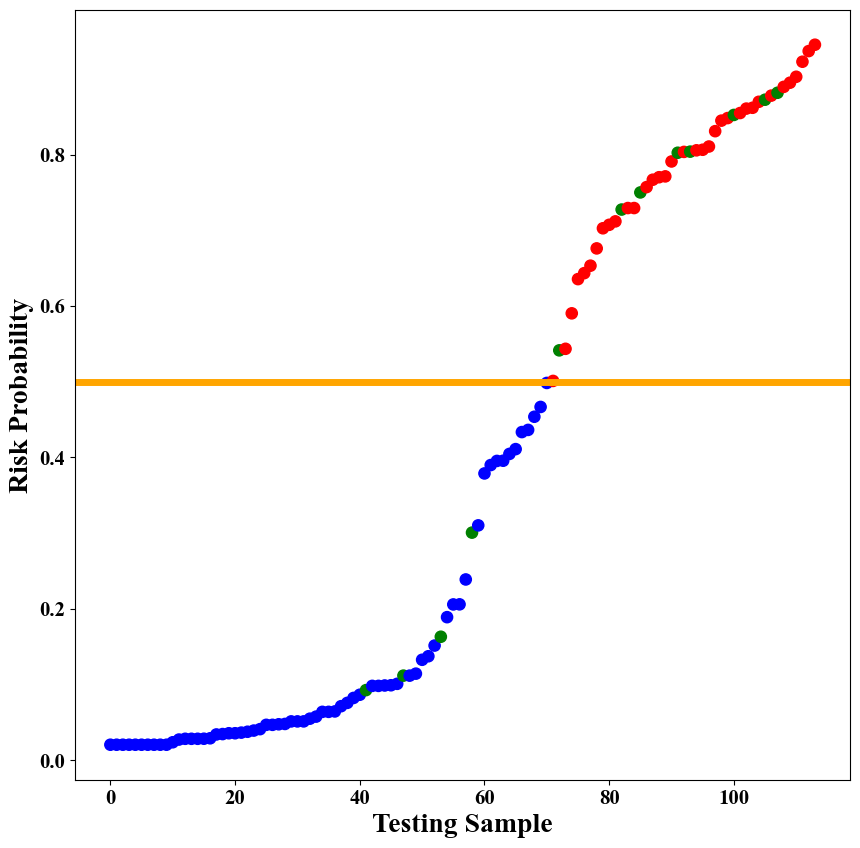

In [50]:
plt.figure(figsize=(10,10))

plt.scatter(list(range(len(sorted_b))),sorted_b,color=sorted_e,s=65)
plt.axhline(0.5,color='orange',linewidth=5)

plt.xlabel('Testing Sample',fontsize=20,fontproperties = 'Times New Roman',fontweight = "bold")
plt.ylabel('Risk Probability',fontsize=20,fontproperties = 'Times New Roman',fontweight = "bold")

plt.xticks(fontproperties = 'Times New Roman',fontsize=15,fontweight = "bold")
plt.yticks(fontproperties = 'Times New Roman',fontsize=15,fontweight = "bold")
plt.show()


## Summary 

In [20]:
from sklearn import metrics

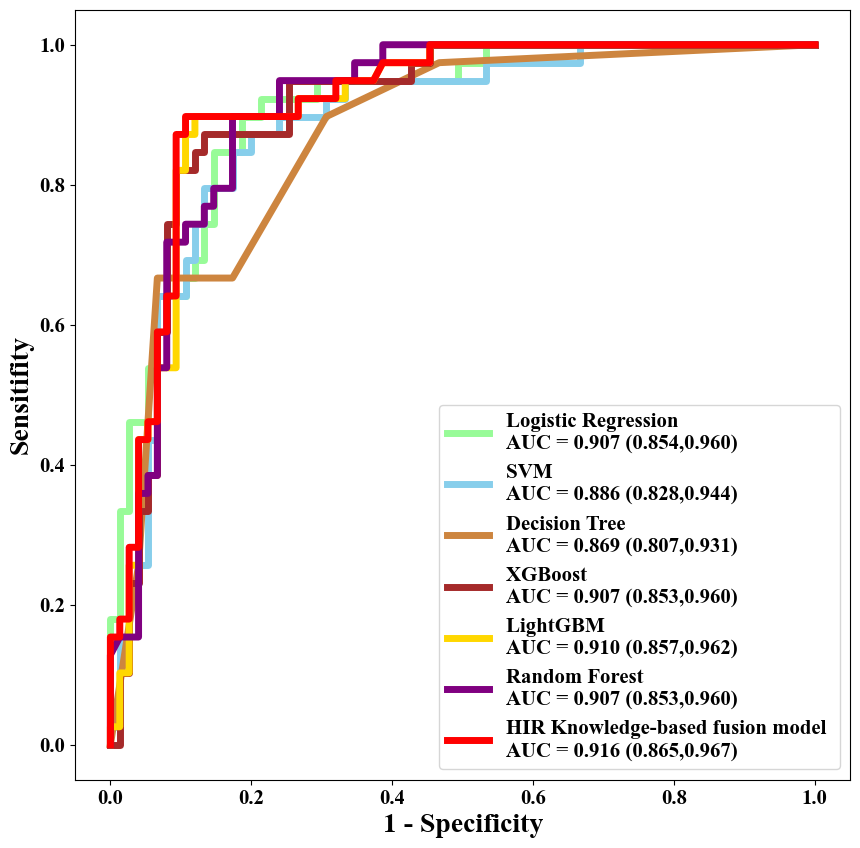

In [27]:
plt.figure(figsize=(10,10))

y_pred_proba_lr = best_model_lr.predict_proba(X_test_sc)[:,1]
fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_proba_lr)
auc = metrics.roc_auc_score(y_test, y_pred_proba_lr)
ci_length = z_value * np.sqrt((auc * (1 - auc)) / y_test.shape[0])
ci_lower = auc - ci_length
ci_upper = auc + ci_length
plt.plot(fpr,tpr,label=f"Logistic Regression \nAUC = {format(auc,'.3f')} ({format(ci_lower,'.3f')},{format(ci_upper,'.3f')})",linewidth=5,color='palegreen') #, AUC = "+str(round(auc,4)),linewidth=3)

y_pred_proba_svm = 1/ (1+np.exp(-best_model_svm.decision_function(X_test_sc))) 
fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_proba_svm)
auc = metrics.roc_auc_score(y_test, y_pred_proba_svm)
ci_length = z_value * np.sqrt((auc * (1 - auc)) / y_test.shape[0])
ci_lower = auc - ci_length
ci_upper = auc + ci_length
plt.plot(fpr,tpr,label=f"SVM \nAUC = {format(auc,'.3f')} ({format(ci_lower,'.3f')},{format(ci_upper,'.3f')})",linewidth=5,color='skyblue') #, AUC = "+str(round(auc,4)),linewidth=3)

y_pred_proba_dt = best_model_dt.predict_proba(X_test)[:,1]
fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_proba_dt)
auc = metrics.roc_auc_score(y_test, y_pred_proba_dt)
ci_length = z_value * np.sqrt((auc * (1 - auc)) / y_test.shape[0])
ci_lower = auc - ci_length
ci_upper = auc + ci_length
plt.plot(fpr,tpr,label=f"Decision Tree \nAUC = {format(auc,'.3f')} ({format(ci_lower,'.3f')},{format(ci_upper,'.3f')})",linewidth=5,color='peru') #, AUC = "+str(round(auc,4)),linewidth=3)


y_pred_proba_xgb = best_model_xgb.predict_proba(X_test_sc)[:, 1]  
fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_proba_xgb)
auc = metrics.roc_auc_score(y_test, y_pred_proba_xgb)
ci_length = z_value * np.sqrt((auc * (1 - auc)) / y_test.shape[0])
ci_lower = auc - ci_length
ci_upper = auc + ci_length
plt.plot(fpr,tpr,label=f"XGBoost \nAUC = {format(auc,'.3f')} ({format(ci_lower,'.3f')},{format(ci_upper,'.3f')})",linewidth=5,color='brown') #, AUC = "+str(round(auc,4)),linewidth=3)



y_pred_proba_gbm = best_model_gbm.predict_proba(X_test_sc)[:, 1]  
fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_proba_gbm)
auc = metrics.roc_auc_score(y_test, y_pred_proba_gbm)
ci_length = z_value * np.sqrt((auc * (1 - auc)) / y_test.shape[0])
ci_lower = auc - ci_length
ci_upper = auc + ci_length
plt.plot(fpr,tpr,label=f"LightGBM \nAUC = {format(auc,'.3f')} ({format(ci_lower,'.3f')},{format(ci_upper,'.3f')})",linewidth=5,color='gold') #, AUC = "+str(round(auc,4)),linewidth=3)




y_pred_proba_rf = best_model_rf.predict_proba(X_test)[:, 1]  
fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_proba_rf)
auc = metrics.roc_auc_score(y_test, y_pred_proba_rf)
ci_length = z_value * np.sqrt((auc * (1 - auc)) / y_test.shape[0])
ci_lower = auc - ci_length
ci_upper = auc + ci_length
plt.plot(fpr,tpr,label=f"Random Forest \nAUC = {format(auc,'.3f')} ({format(ci_lower,'.3f')},{format(ci_upper,'.3f')})",linewidth=5,color='purple') #, AUC = "+str(round(auc,4)),linewidth=3)


# fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_prob_voting)
# auc = metrics.roc_auc_score(y_test, y_pred_prob_voting)
# plt.plot(fpr,tpr,label=f"Voting \n (AUC = {round(auc,4)})",linewidth=3,color='blue')#, AUC = "+str(round(auc,4)),linewidth=3)


# fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_prob_stacking)
# auc = metrics.roc_auc_score(y_test, y_pred_prob_stacking)
# plt.plot(fpr,tpr,label=f"Stacking \n (AUC = {round(auc,4)})",linewidth=3,color='green')#, AUC = "+str(round(auc,4)),linewidth=3)

y_pred_proba_hir = np.array(result_best_hir[0][0])
fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_proba_hir)
auc = metrics.roc_auc_score(y_test, y_pred_proba_hir)
ci_length = z_value * np.sqrt((auc * (1 - auc)) / y_test.shape[0])
ci_lower = auc - ci_length
ci_upper = auc + ci_length
plt.plot(fpr,tpr,label=f"HIR Knowledge-based fusion model \nAUC = {format(auc,'.3f')} ({format(ci_lower,'.3f')},{format(ci_upper,'.3f')})",linewidth=5,color='red') #, AUC = "+str(round(auc,4)),linewidth=3)




plt.xlabel('1 - Specificity',fontsize=20,fontproperties = 'Times New Roman',fontweight = "bold")
plt.ylabel('Sensitifity',fontsize=20,fontproperties = 'Times New Roman',fontweight = "bold")


plt.xticks(fontproperties = 'Times New Roman',fontsize=15,fontweight = "bold")
plt.yticks(fontproperties = 'Times New Roman',fontsize=15,fontweight = "bold")

plt.legend(loc=4,prop={'size': 15,'family' : 'Times New Roman','weight':'bold'})

plt.savefig('figures/roc_auc_six.jpg',dpi=300)